# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import operator
import string
import random
import seaborn as sns
from wordcloud import WordCloud

In [2]:
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import WordNetLemmatizer    # module for lemmatization
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

# Load data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data = pd.read_csv("/content/gdrive/MyDrive/NLP/data/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Clean data

Before cleaning the data, we try to balance more the proportion of clean and toxic comments

In [5]:
x=data.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=data.iloc[:,2:].sum(axis=1)
data['clean']=(rowsums==0)
#count number of clean entries
data['clean'].sum()
print("Total comments = ",len(data))
print("Total clean comments = ",data['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


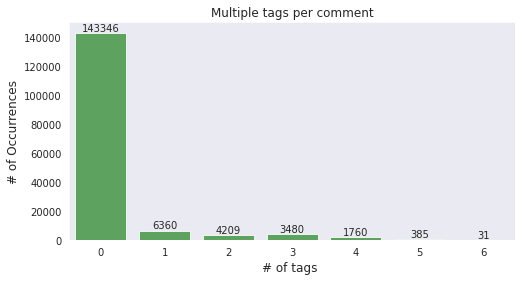

In [6]:
x=rowsums.value_counts()
color = sns.color_palette()
sns.set_style("dark")
#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [7]:
drop_indices = np.random.choice(data[data.clean == True].index, 100_000, replace=False)

print(drop_indices)

[70405 76566 53024 ... 33314 16349 66325]


In [8]:
data = data.drop(drop_indices)

In [9]:
data = data.reset_index().drop(columns=['index'])

In [10]:
# function cleaning a list of comment
def clean(data):

  # Remove URLs
  data['comment_text'] = data['comment_text'].apply(lambda x: re.sub(r'http\S+', '', x))

  # Remove punctuation
  data['comment_text'] = data['comment_text'].apply(lambda x: re.sub('[%s]' % re.escape(r'!"#$%&\'()*+,-./:;<·=>?@[\]^_`{|}~'), '' , x))

  # Lower case the comments
  data['comment_text'] = data['comment_text'].apply(lambda x: x.lower())

  # Remove digits
  data['comment_text'] = data['comment_text'].apply(lambda x: re.sub('[%s]' % re.escape('0123456789'), '' , x))

  # Remove \n
  data['comment_text'] = data['comment_text'].apply(lambda x: re.sub('\n', ' ' , x))

  # Remove mutiple spaces
  data['comment_text'] = data['comment_text'].apply(lambda x: re.sub('\s+', ' ' , x))

  # Remove starting\ending spaces
  data['comment_text'] = data['comment_text'].apply(lambda x: re.sub('^ | $', '' , x))
  
  return data

In [11]:
# Import the english stop words list from NLTK
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))  

def simplify(data):

  def clean_words(sentence):
    wordnet_lemmatizer = WordNetLemmatizer()
    #tokenizer = TweetTokenizer(preserve_case = False, strip_handles = True, reduce_len = True)
    #tokens = tokenizer.tokenize(sentence)
    tokens = sentence.split(" ")
    clean = []
    for word in tokens:
        if (word not in stop_words and  # remove stopwords
                  word not in string.punctuation) and 'wiki' not in word:  # remove punctuation
            lemma_word = wordnet_lemmatizer.lemmatize(word)  # Lemmatizing word
            clean.append(lemma_word)
    return ' '.join(clean)
  

  data['comment_text'] = data['comment_text'].apply(clean_words)

  return data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
data = clean(data)

In [13]:
data = simplify(data)

In [14]:
# Print a comment for testing
l = random.sample(range(0, len(data)), 10)
for number in l :
  print(data['comment_text'][number])
  print('___________________________')

user syrthiss motherfucker asshole ha ha ha
___________________________
thatd alright im bureaucrat youd ask request one see thanks talk
___________________________
chernobyl disaster
___________________________
good luck struggle forcing bullshit iranian article make afghani part persian iranian nation delete azeri kurd iranian deleted problem afghani iranian persian iranian persian accept dont know afghan obsessed iran
___________________________
penis sex grawp haep penis penis vagina vagina
___________________________
oh yeah well fuckass ha claymort
___________________________
suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing fascist fuck suppressing

In [15]:
!pip install fasttext

In [16]:
import fasttext

In [17]:
# Training the languages detection model
path_to_pretrained_model = "/content/gdrive/MyDrive/NLP/bag_of_word/lid.176.ftz"
fmodel = fasttext.load_model(path_to_pretrained_model)

In [18]:
# Applying the languages detection model to our data
def detect_lang_except(l):
  no_features = 0
  try:
      return fmodel.predict(l)[0][0][9:]
  except Exception:
      no_features += 1

In [19]:
# Detecting the language of each email's content
language = data["comment_text"].apply(detect_lang_except)

In [20]:
for l in set(language.values):
  c = sum(language.values == l)
  if c > 0 :
    print(f'{c} occurences of language {l}')

1 occurences of language scn
39 occurences of language pl
1 occurences of language he
2 occurences of language be
9 occurences of language lt
4 occurences of language uz
1 occurences of language pam
310 occurences of language fr
10 occurences of language br
6 occurences of language cy
4 occurences of language xal
2 occurences of language bn
5 occurences of language jbo
3 occurences of language als
7 occurences of language cs
1 occurences of language ml
2 occurences of language sco
2 occurences of language kn
2 occurences of language bg
6 occurences of language ar
519 occurences of language de
6 occurences of language sl
18 occurences of language no
13 occurences of language da
1 occurences of language mn
1 occurences of language kk
6 occurences of language sr
57507 occurences of language en
1 occurences of language vec
39 occurences of language pt
28 occurences of language la
1 occurences of language hsb
3 occurences of language tyv
41 occurences of language sv
4 occurences of language

In [21]:
#We only keep english
data = data[language.values == 'en']

In [22]:
print(len(data))

57507


In [23]:
data['comment_text'].head(25)

0     explanation edits made username hardcore metal...
1                congratulation well use tool well talk
2                           cocksucker piss around work
3     vandalism matt shirvington article reverted pl...
4                  alignment subject contrary dulithgow
5     hey talk exclusive group wp talibanswho good d...
6     oh girl started argument stuck nose doesnt bel...
7     juelz santanas age juelz santana year old came...
8          bye dont look come think comming back tosser
9     regarding recent edits please read wpfilmplot ...
10    signpost september read signpost full singlepa...
11    reconsidering st paragraph edit dont understan...
12    radial symmetry several extinct lineage includ...
13    yes mother child case michael jackson studied ...
14        praise looked article month ago much improved
15    well process thing subpages rfa listed nosepte...
16    gay antisemmitian archangel white tiger meow g...
17                            fuck filthy mother

In [24]:
toxic_cloud = WordCloud(width=1000, height=600,background_color="white").generate(' '.join(data[data.toxic == 1]['comment_text']))
severe_toxic_cloud = WordCloud(width=1000, height=600,background_color="white").generate(' '.join(data[data.severe_toxic == 1]['comment_text']))
obscene_cloud = WordCloud(width=1000, height=600,background_color="white").generate(' '.join(data[data.obscene == 1]['comment_text']))
threat_cloud = WordCloud(width=1000, height=600,background_color="white").generate(' '.join(data[data.threat == 1]['comment_text']))
insult_cloud = WordCloud(width=1000, height=600,background_color="white").generate(' '.join(data[data.insult == 1]['comment_text']))
identity_hate_cloud = WordCloud(width=1000, height=600,background_color="white").generate(' '.join(data[data.identity_hate == 1]['comment_text']))

(-0.5, 999.5, 599.5, -0.5)

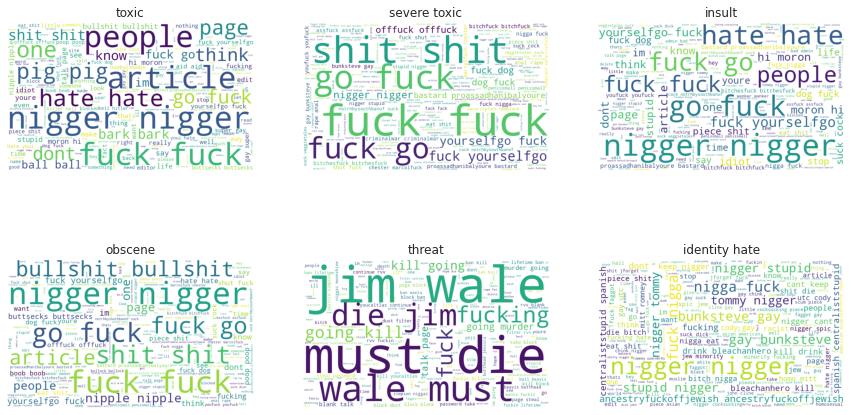

In [25]:
fig, axs = plt.subplots(2, 3,figsize=(15,8))

axs[0, 0].imshow(toxic_cloud)
axs[0, 0].set_title('toxic')
axs[0, 0].axis("off")
axs[0, 1].imshow(severe_toxic_cloud )
axs[0, 1].set_title('severe toxic')
axs[0, 1].axis("off")
axs[1, 0].imshow(obscene_cloud)
axs[1, 0].set_title('obscene')
axs[1, 0].axis("off")
axs[1, 1].imshow(threat_cloud)
axs[1, 1].set_title('threat')
axs[1, 1].axis("off")
axs[0, 2].imshow(insult_cloud)
axs[0, 2].set_title('insult')
axs[0, 2].axis("off")
axs[1, 2].imshow(identity_hate_cloud)
axs[1, 2].set_title('identity hate')
axs[1, 2].axis("off")

# Make the vocabulary

## Vocabulary containing every word in every comment

In [26]:
# Split all comments to have a list of word
split_comment = data['comment_text'].apply(lambda x: x.split(' '))

In [27]:
vocabulary = {}

In [28]:
# Count number of occurence of each word
for text in split_comment:
  for word in text:
    if not word in vocabulary.keys():
      vocabulary[word] = 1
    else:
      vocabulary[word] += 1

In [29]:
print('Vocabulary size before thresholding : {} words'.format(len(vocabulary)))

Vocabulary size before thresholding : 102991 words


## Thresholding to remove rare words from the vocabulary

In [30]:
# Sort the vocabulary
sorted_vocabulary = dict(sorted(vocabulary.items(), key=operator.itemgetter(1),reverse=True))

In [31]:
threshold = 50 # words appearing less than 'threshold' times are removed
vocabulary = {k: v for k, v in sorted_vocabulary.items() if v >= threshold}

In [32]:
print('Vocabulary size after thresholding : {} words'.format(len(vocabulary)))

Vocabulary size after thresholding : 4266 words


In [33]:
# List of all kept words
key_word_list = list(vocabulary.keys())

## Make x_train

In [34]:
x_train = np.zeros((len(split_comment),len(vocabulary)),dtype  = np.float32)
i = 0
for j in split_comment.index:
  if i%10000 == 0:
    print(i)
  for word in split_comment[j]:
    if word in key_word_list:
      index = key_word_list.index(word)
      x_train[i,index]+=1
  i+=1

0
10000
20000
30000
40000
50000


In [35]:
print(x_train.shape)
x_train

(57507, 4266)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
np.save('/content/gdrive/MyDrive/NLP/bag_of_word/x_train_threshold_100',x_train)

## Make y_train

In [37]:
y_train = np.zeros((len(split_comment),6))
i=0
for k in data.index:
  for j,label in enumerate(['toxic','severe_toxic', 'obscene', 'threat','insult', 'identity_hate']):
    y_train[i,j] = data[label][k]
  i+=1

In [38]:
np.save('/content/gdrive/MyDrive/NLP/y_train_threshold_100',y_train)

# Make x_test and y_test

In [39]:
data_y_test = pd.read_csv("/content/gdrive/MyDrive/NLP/data/test_labels.csv")
data_y_test = data_y_test[data_y_test.toxic > -1]
data_y_test.head(20)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


We process again to randomly dropping some data

In [40]:
drop_indices = np.random.choice(data_y_test.index, 50_000, replace=False)

print(drop_indices)

[ 34934  45449  17820 ... 114655  32524 120603]


In [41]:
data_y_test = data_y_test.drop(drop_indices)

In [42]:
data_y_test = data_y_test.reset_index().drop(columns=['index'])

In [43]:
y_test = np.zeros((len(data_y_test),6))
for i in range(len(data_y_test)):
  for j,label in enumerate(['toxic','severe_toxic', 'obscene', 'threat','insult', 'identity_hate']):
    y_test[i,j] = data_y_test[label].iloc[i]

In [44]:
np.save('/content/gdrive/MyDrive/NLP/bag_of_word/y_test_threshold_100',y_test)

In [45]:
data_x_test = pd.read_csv("/content/gdrive/MyDrive/NLP/data/test.csv")
data_x_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [46]:
data_x_test = pd.merge(data_x_test, data_y_test, on=["id"])
data_x_test.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
1,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
2,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
3,000663aff0fffc80,this other one from 1897,0,0,0,0,0,0
4,000844b52dee5f3f,|blocked]] from editing Wikipedia. |,0,0,0,0,0,0
5,00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
6,000bafe2080bba82,. \n\n Jews are not a race because y...,0,0,0,0,0,0
7,0013a435effa29bd,"I'd never think I'd need to say it, but Wikipe...",0,0,0,0,0,0
8,00177176f33f587e,== Can you work your magic? == \n\n Hi. I was...,0,0,0,0,0,0
9,0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0


In [47]:
data_x_test = clean(data_x_test)

In [48]:
data_x_test = simplify(data_x_test)

In [49]:
# Print a comment for testing
l = random.sample(range(0, len(data_x_test)), 10)
for number in l :
  print(data_x_test['comment_text'][number])
  print('___________________________')

edits ok thanks repeated ref double stitched last longer cheer ceegee
___________________________
persian origin persia huge spoke persian language tunis occupied persian force berber supported berber stupid nation couldnt create state homeland historian speak bout thaert kingdom bout somekind rustamid emiraat like hell possible turn berber stupid nation since one completely destroyid umayyadsarab occupier
___________________________
someone please unprotect goddam thing make extremely constructive edits would really shape article already wham article semiprotected fuck sake community hardly limited special registered user think person registered arent still vandal grow handle onslaught vandalism obviously important article need aid top contributer also known anonymous
___________________________
best find isnt really saying much ° net
___________________________
unusual cargo friend went wheel sailing boat sharing excursion boat two image tell story wheelpassengersjpg wheel ascensionj

In [50]:
split_comment_test = data_x_test['comment_text'].apply(lambda x: x.split(' '))

In [51]:
x_test = np.zeros((len(split_comment_test),len(vocabulary)),dtype  = np.float32)
for i in range(x_test.shape[0]):
  if i%1000 == 0:
    print(i)
  for word in split_comment_test[i]:
    if word in key_word_list:
      index = key_word_list.index(word)
      x_test[i,index]+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [52]:
np.save('/content/gdrive/MyDrive/NLP/bag_of_word/x_test_threshold_100',x_test)

#TF-idf part

In [53]:
#We have to concatenate train and test set to do the td_idf vectorization and resplit them later so that we have coherent matrix shapes

all_data = pd.concat([split_comment,split_comment_test])


In [54]:
def keep_vocab(sentence):
  return ' '.join([w for w in sentence if w in vocabulary])

In [55]:
words = all_data.apply(keep_vocab)

In [56]:
words.head(10)

0    explanation edits made username hardcore fan r...
1               congratulation well use tool well talk
2                          cocksucker piss around work
3    vandalism matt article reverted please dont ba...
4                                     subject contrary
5    hey talk exclusive group wp good destroying ga...
6    oh girl started argument stuck nose doesnt bel...
7    age year old came february th make turn making...
8                        bye dont look come think back
9    regarding recent edits please read editing fil...
Name: comment_text, dtype: object

In [57]:
words[list(data[data.toxic == 1].index)].head(10)

2                           cocksucker piss around work
2     adding new product list make sure relevant add...
5     hey talk exclusive group wp good destroying ga...
5     arab genocide iraq protest europe may europe a...
8                         bye dont look come think back
8     work hi time help article e b input would appr...
16    gay white tiger two way erased comment holocau...
16                                                     
17                                fuck filthy mother as
17    black word kill many people king kill many peo...
Name: comment_text, dtype: object

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(words)

x = x.toarray()

In [59]:
x_train2 = x[:len(split_comment)]
x_test2 = x[len(split_comment):]

In [60]:
print(x_train2.shape)
x_train2

(57507, 4239)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
print(x_test2.shape)
x_test2

(13978, 4239)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
np.save('/content/gdrive/MyDrive/NLP/bag_of_word/x_train_threshold_100_tf_idf',x_train2.astype(np.float32))

In [63]:
np.save('/content/gdrive/MyDrive/NLP/bag_of_word/x_test_threshold_100_tf_idf',x_test2.astype(np.float32))